# Import Lib

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import math
from matplotlib import pyplot
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import Flatten

# Import Data
[Data Website](https://data.gov.sg/dataset/job-vacancy-by-industry-and-occupational-group-quarterly?resource_id=3ba4be1b-b954-4db8-9c0f-d7a3745f8294)

In [2]:
df_topline = pd.read_csv('job-vacancy-topline.csv')
df_by_industry_level_1 =  pd.read_csv('job-vacancy-by-industry-level1.csv')
df_by_industry_level_2 =  pd.read_csv('job-vacancy-by-industry-level2.csv')
df_by_industry_level_3 =  pd.read_csv('job-vacancy-by-industry-level3.csv')
df_by_broad_occupational_group =  pd.read_csv('job-vacancy-by-broad-occupational-group.csv')

# Data Preprocessing 

## Data Cleaning

### Data Overview

In [3]:
### Check dataset
### Level 3 is included (topline, level1, level2)

print(df_topline.head())
print('---------------------------------------------------')
print(df_by_industry_level_1.head())
print('---------------------------------------------------')
print(df_by_industry_level_2.head())
print('---------------------------------------------------')
print(df_by_industry_level_3.head())
print('---------------------------------------------------')
print(df_by_broad_occupational_group.head())

   quarter  job_vacancy
0  1990-Q1        45100
1  1990-Q2        46100
2  1990-Q3        47300
3  1990-Q4        36100
4  1991-Q1        40400
---------------------------------------------------
   quarter      industry1 job_vacancy
0  1990-Q1  manufacturing       26400
1  1990-Q1   construction        1700
2  1990-Q1       services       17000
3  1990-Q1         others         100
4  1990-Q2  manufacturing       26500
---------------------------------------------------
   quarter      industry1                        industry2 job_vacancy
0  1990-Q1  manufacturing      food, beverages and tobacco         500
1  1990-Q1  manufacturing      textile and wearing apparel        5100
2  1990-Q1  manufacturing    paper products and publishing        1100
3  1990-Q1  manufacturing  petroleum and chemical products         600
4  1990-Q1  manufacturing      rubber and plastic products        1100
---------------------------------------------------
   quarter      industry1                     

In [4]:
print(df_by_industry_level_2.tail())
print('---------------------------------------------------')
print(df_by_industry_level_3.tail())

      quarter industry1                                industry2 job_vacancy
2439  2021-Q2  services                     real estate services        1500
2440  2021-Q2  services                    professional services        7100
2441  2021-Q2  services      administrative and support services        6200
2442  2021-Q2  services  community, social and personal services       16900
2443  2021-Q2    others                                   others         800
---------------------------------------------------
      quarter industry1                                industry2  \
3715  2021-Q2  services  community, social and personal services   
3716  2021-Q2  services  community, social and personal services   
3717  2021-Q2  services  community, social and personal services   
3718  2021-Q2  services  community, social and personal services   
3719  2021-Q2    others                                   others   

                                          industry3 job_vacancy  
3715       

In [5]:
df_by_broad_occupational_group['occupation1'].value_counts()

clerical, sales and services workers                          126
professional, managers, executive and technicians             126
production and transport operators, cleaners and labourers    126
Name: occupation1, dtype: int64

### Check Null, data is good with no null values

In [6]:
print(df_by_industry_level_3.isnull().sum())
print(df_by_broad_occupational_group.isnull().sum())

quarter        0
industry1      0
industry2      0
industry3      0
job_vacancy    0
dtype: int64
quarter        0
occupation1    0
job_vacancy    0
dtype: int64


### Check data type, data has wrong types declared for "job_vacancy"  

In [7]:
print(df_by_industry_level_3.info())
print(df_by_broad_occupational_group.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3720 entries, 0 to 3719
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   quarter      3720 non-null   object
 1   industry1    3720 non-null   object
 2   industry2    3720 non-null   object
 3   industry3    3720 non-null   object
 4   job_vacancy  3720 non-null   object
dtypes: object(5)
memory usage: 145.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   quarter      378 non-null    object
 1   occupation1  378 non-null    object
 2   job_vacancy  378 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 9.0+ KB
None


#### Change data type and checking

In [8]:
df_by_industry_level_3['job_vacancy_transformed'] = pd.to_numeric(df_by_industry_level_3['job_vacancy'], errors='coerce')

##### There is error in converting data type

In [9]:
df_by_industry_level_3.isnull().sum()

quarter                     0
industry1                   0
industry2                   0
industry3                   0
job_vacancy                 0
job_vacancy_transformed    38
dtype: int64

In [10]:
df_by_industry_level_3.loc[df_by_industry_level_3.job_vacancy_transformed.isnull()]

,quarter,industry1,industry2,industry3,job_vacancy,job_vacancy_transformed
321,1993-Q2,others,others,others,-,NaN
344,1993-Q3,others,others,others,-,NaN
367,1993-Q4,others,others,others,-,NaN
413,1994-Q2,others,others,others,-,NaN
436,1994-Q3,others,others,others,-,NaN
459,1994-Q4,others,others,others,-,NaN
482,1995-Q1,others,others,others,-,NaN
505,1995-Q2,others,others,others,-,NaN
551,1995-Q4,others,others,others,-,NaN
597,1996-Q2,others,others,others,-,NaN


##### Based on data website, '-' is mean the data is negligible or not significant, therefore we decide to keep it as 0
[Data Website](https://data.gov.sg/dataset/job-vacancy-by-industry-and-occupational-group-quarterly?resource_id=3ba4be1b-b954-4db8-9c0f-d7a3745f8294)

In [11]:
df_by_industry_level_3.fillna(0, inplace = True)
df_by_industry_level_3

,quarter,industry1,industry2,industry3,job_vacancy,job_vacancy_transformed
0,1990-Q1,manufacturing,"food, beverages and tobacco","food, beverages and tobacco",500,500.0
1,1990-Q1,manufacturing,textile and wearing apparel,textile and wearing apparel,5100,5100.0
2,1990-Q1,manufacturing,paper products and publishing,paper products and publishing,1100,1100.0
3,1990-Q1,manufacturing,petroleum and chemical products,petroleum and chemical products,600,600.0
4,1990-Q1,manufacturing,rubber and plastic products,rubber and plastic products,1100,1100.0
...,...,...,...,...,...,...
3715,2021-Q2,services,"community, social and personal services",public administration and education,9700,9700.0
3716,2021-Q2,services,"community, social and personal services",health and social services,5000,5000.0
3717,2021-Q2,services,"community, social and personal services","arts, entertainment and recreation",1200,1200.0
3718,2021-Q2,services,"community, social and personal services","other community, social and personal services",1100,1100.0


## Data Integration & Transformation

### Integrate df_by_industry_level_3, df_by_broad_occupational_group

#### Fix data point not match & change to time series format

In [12]:
df_by_industry_level_3.loc[df_by_industry_level_3['industry1'] == 'services']['industry3'].value_counts()

wholesale trade                                    126
retail trade                                       126
other community, social and personal services       86
air transport and supporting services               86
other transport and storage services                86
water transport and supporting services             86
it and other information services                   86
land transport and supporting services              86
architectural and engineering services              86
other professional services                         86
legal, accounting and management services           86
financial institutions                              64
restaurants                                         64
hotels                                              64
accommodation                                       62
food and beverage services                          62
arts, entertainment and recreation                  62
other adminstrative and support services            62
health and

In [13]:
df_by_industry_level_3['industry3'].value_counts()

construction                                          126
transport equipment                                   126
wholesale trade                                       126
other manufacturing industries                        126
retail trade                                          126
others                                                126
food, beverages and tobacco                           126
other transport and storage services                   86
petroleum, chemical and pharmaceutical products        86
legal, accounting and management services              86
it and other information services                      86
architectural and engineering services                 86
water transport and supporting services                86
other professional services                            86
other community, social and personal services          86
air transport and supporting services                  86
land transport and supporting services                 86
financial inst

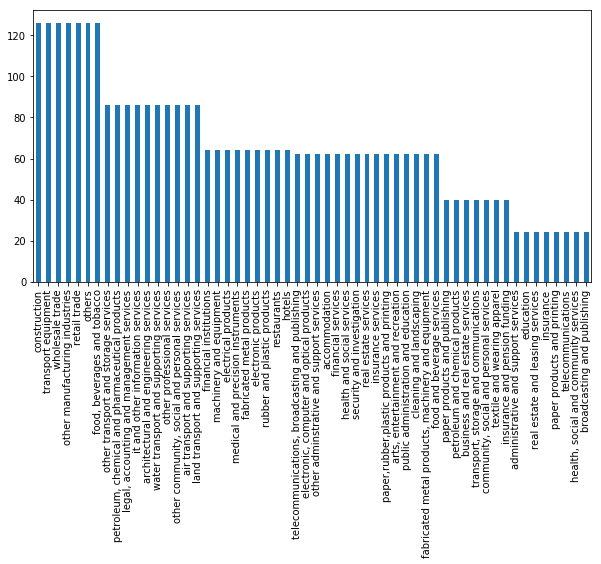

In [14]:
plt.figure(figsize=(10, 5))
df_by_industry_level_3['industry3'].value_counts().plot(kind='bar')

In [15]:
### Some job only start on later 
print(df_by_industry_level_3[df_by_industry_level_3['industry3']  == 'wholesale trade']) #1990
print(df_by_industry_level_3[df_by_industry_level_3['industry3']  == 'accommodation']) #2006

      quarter industry1                   industry2        industry3  \
13    1990-Q1  services  wholesale and retail trade  wholesale trade   
36    1990-Q2  services  wholesale and retail trade  wholesale trade   
59    1990-Q3  services  wholesale and retail trade  wholesale trade   
82    1990-Q4  services  wholesale and retail trade  wholesale trade   
105   1991-Q1  services  wholesale and retail trade  wholesale trade   
...       ...       ...                         ...              ...   
3568  2020-Q2  services  wholesale and retail trade  wholesale trade   
3600  2020-Q3  services  wholesale and retail trade  wholesale trade   
3632  2020-Q4  services  wholesale and retail trade  wholesale trade   
3664  2021-Q1  services  wholesale and retail trade  wholesale trade   
3696  2021-Q2  services  wholesale and retail trade  wholesale trade   

     job_vacancy  job_vacancy_transformed  
13          1600                   1600.0  
36          1600                   1600.0  
59 

In [16]:
### Convert to time series form
df2 = df_by_industry_level_3.pivot(columns='industry3', values='job_vacancy_transformed')
Pivoted = pd.concat([df2[series].dropna().reset_index(drop=True) for series in df2], axis=1)

In [17]:
### Fill 0 for late start job at earlier time
for items in Pivoted.columns:
    Pivoted[items] = Pivoted[items].shift(126 - len(Pivoted.loc[Pivoted[items].notnull()]))
    
Pivoted.fillna(0, inplace = True)

In [18]:
### Convert to time series form
df3 = df_by_broad_occupational_group.pivot(columns='occupation1', values='job_vacancy')
Pivoted2 = pd.concat([df3[series].dropna().reset_index(drop=True) for series in df3], axis=1)

In [19]:
### Set index for time series
Pivoted.set_index(df_by_industry_level_3['quarter'].drop_duplicates())
Pivoted2.set_index(df_by_industry_level_3['quarter'].drop_duplicates())

,"clerical, sales and services workers","production and transport operators, cleaners and labourers","professional, managers, executive and technicians"
quarter,,,
1990-Q1,13300.0,25700.0,6100.0
1990-Q2,13700.0,26900.0,5600.0
1990-Q3,15200.0,26300.0,5700.0
1990-Q4,10800.0,20400.0,4900.0
1991-Q1,12200.0,22600.0,5600.0
...,...,...,...
2020-Q2,8300.0,8500.0,26000.0
2020-Q3,11600.0,11500.0,30200.0
2020-Q4,10600.0,12900.0,29500.0


In [20]:
### Integrate
df_integrated = pd.concat([Pivoted, Pivoted2], axis=1).reindex(Pivoted.index)
df_integrated

,accommodation,administrative and support services,air transport and supporting services,architectural and engineering services,"arts, entertainment and recreation",broadcasting and publishing,business and real estate services,cleaning and landscaping,"community, social and personal services",construction,...,telecommunications,"telecommunications, broadcasting and publishing",textile and wearing apparel,transport equipment,"transport, storage and communications",water transport and supporting services,wholesale trade,"clerical, sales and services workers","production and transport operators, cleaners and labourers","professional, managers, executive and technicians"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1700.0,...,0.0,0.0,0.0,1800.0,0.0,0.0,1600.0,13300.0,25700.0,6100.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2100.0,...,0.0,0.0,0.0,2000.0,0.0,0.0,1600.0,13700.0,26900.0,5600.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3100.0,...,0.0,0.0,0.0,2300.0,0.0,0.0,1700.0,15200.0,26300.0,5700.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000.0,...,0.0,0.0,0.0,2300.0,0.0,0.0,1400.0,10800.0,20400.0,4900.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2300.0,...,0.0,0.0,0.0,2800.0,0.0,0.0,1600.0,12200.0,22600.0,5600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,800.0,700.0,100.0,400.0,500.0,200.0,1400.0,1200.0,1600.0,900.0,...,200.0,500.0,300.0,200.0,1900.0,300.0,3800.0,8300.0,8500.0,26000.0
122,900.0,1200.0,100.0,800.0,800.0,200.0,1700.0,1600.0,2000.0,3500.0,...,200.0,600.0,300.0,400.0,2400.0,400.0,3100.0,11600.0,11500.0,30200.0
123,500.0,900.0,100.0,800.0,800.0,100.0,1600.0,1500.0,2500.0,4900.0,...,200.0,700.0,300.0,500.0,2000.0,600.0,3000.0,10600.0,12900.0,29500.0
124,900.0,1400.0,100.0,1200.0,1000.0,200.0,2800.0,1200.0,2400.0,6500.0,...,200.0,900.0,500.0,1300.0,3200.0,1100.0,4200.0,12900.0,16500.0,37600.0


In [21]:
df_integrated['Date'] = pd.date_range(start='1/1/1990', end='8/1/2021', freq ='Q')
df_integrated.set_index(['Date'], inplace = True)
# df_integrated = df_integrated[40:]

## Data Reduction

In [22]:
Target = df_integrated['it and other information services']
Feature = df_integrated.drop(['it and other information services'], axis = 1)

### Correlation (Drop highly correlated features)

In [23]:
cor_matrix = Feature.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
to_drop

['community, social and personal services',
 'other adminstrative and support services',
 'petroleum and chemical products',
 'real estate and leasing services',
 'transport, storage and communications',
 'professional, managers, executive and technicians']

In [24]:
cor_matrix.style.background_gradient(cmap='coolwarm').set_precision(2)

In [25]:
Feature = Feature.drop(to_drop, axis=1)
Feature

,accommodation,administrative and support services,air transport and supporting services,architectural and engineering services,"arts, entertainment and recreation",broadcasting and publishing,business and real estate services,cleaning and landscaping,construction,education,...,rubber and plastic products,security and investigation,telecommunications,"telecommunications, broadcasting and publishing",textile and wearing apparel,transport equipment,water transport and supporting services,wholesale trade,"clerical, sales and services workers","production and transport operators, cleaners and labourers"
Date,,,,,,,,,,,,,,,,,,,,,
1990-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1700.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1800.0,0.0,1600.0,13300.0,25700.0
1990-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2100.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2000.0,0.0,1600.0,13700.0,26900.0
1990-09-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3100.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2300.0,0.0,1700.0,15200.0,26300.0
1990-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2300.0,0.0,1400.0,10800.0,20400.0
1991-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2300.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2800.0,0.0,1600.0,12200.0,22600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-30,800.0,700.0,100.0,400.0,500.0,200.0,1400.0,1200.0,900.0,200.0,...,300.0,1500.0,200.0,500.0,300.0,200.0,300.0,3800.0,8300.0,8500.0
2020-09-30,900.0,1200.0,100.0,800.0,800.0,200.0,1700.0,1600.0,3500.0,200.0,...,300.0,1900.0,200.0,600.0,300.0,400.0,400.0,3100.0,11600.0,11500.0
2020-12-31,500.0,900.0,100.0,800.0,800.0,100.0,1600.0,1500.0,4900.0,100.0,...,400.0,1300.0,200.0,700.0,300.0,500.0,600.0,3000.0,10600.0,12900.0


### Causality 

In [26]:
col_to_drop = []
def is_GrangerCause(data=None, maxlag=27):
    
    
    gc = grangercausalitytests(data, maxlag=maxlag, verbose=False)
    
    for i in range(maxlag):
        x=gc[i+1][0]
        p1 = x['lrtest'][1] # pvalue for lr test
        p2 = x['ssr_ftest'][1] # pvalue for ssr ftest
        p3 = x['ssr_chi2test'][1] #pvalue for ssr_chi2test
        p4 = x['params_ftest'][1] #pvalue for 'params_ftest'
        
        condition = ((p1 < 0.05 and p2 < 0.05) and (p3 < 0.05 and p4 < 0.05))
        
        if condition == True:
            cols = data.columns
            print('Yes: {} Granger causes {}'.format(cols[0], cols[1]))
            print('maxlag = {}\nResults: {}'.format(i, x))
            print("\n")
            break
            
        else:
            if i == maxlag - 1:
                cols = data.columns
                print('No: {} does not Granger cause {}'.format(cols[0], cols[1]))
                col_to_drop.append(cols[0])                       
                

In [27]:
for variable in df_integrated.columns:
    is_GrangerCause(data = df_integrated[[variable, 'it and other information services']])

Yes: accommodation Granger causes it and other information services
maxlag = 22
Results: {'ssr_ftest': (1.8626162211908541, 0.03014451292184601, 56.0, 23), 'ssr_chi2test': (78.7953183571631, 4.969910106517678e-08, 23), 'lrtest': (58.519701481854554, 6.235217489140351e-05, 23), 'params_ftest': (1.8626162211908572, 0.030144512921845668, 56.0, 23.0)}


Yes: administrative and support services Granger causes it and other information services
maxlag = 0
Results: {'ssr_ftest': (19.137745590996992, 2.5788778077441874e-05, 122.0, 1), 'ssr_chi2test': (19.60834589241495, 9.505308010159905e-06, 1), 'lrtest': (18.21441098188734, 1.9737970705547746e-05, 1), 'params_ftest': (19.13774559099695, 2.578877807744208e-05, 122.0, 1.0)}


No: air transport and supporting services does not Granger cause it and other information services
Yes: architectural and engineering services Granger causes it and other information services
maxlag = 0
Results: {'ssr_ftest': (8.777530702484027, 0.0036671751474264343, 122.

In [28]:
Feature = Feature.drop(col_to_drop, axis=1, errors='ignore')
Feature

,accommodation,administrative and support services,architectural and engineering services,"arts, entertainment and recreation",broadcasting and publishing,business and real estate services,cleaning and landscaping,construction,education,electronic products,...,"petroleum, chemical and pharmaceutical products",public administration and education,real estate services,restaurants,telecommunications,"telecommunications, broadcasting and publishing",textile and wearing apparel,wholesale trade,"clerical, sales and services workers","production and transport operators, cleaners and labourers"
Date,,,,,,,,,,,,,,,,,,,,,
1990-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1700.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1600.0,13300.0,25700.0
1990-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2100.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1600.0,13700.0,26900.0
1990-09-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3100.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1700.0,15200.0,26300.0
1990-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1400.0,10800.0,20400.0
1991-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2300.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1600.0,12200.0,22600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-30,800.0,700.0,400.0,500.0,200.0,1400.0,1200.0,900.0,200.0,1900.0,...,500.0,6200.0,900.0,700.0,200.0,500.0,300.0,3800.0,8300.0,8500.0
2020-09-30,900.0,1200.0,800.0,800.0,200.0,1700.0,1600.0,3500.0,200.0,2000.0,...,400.0,7000.0,1200.0,1000.0,200.0,600.0,300.0,3100.0,11600.0,11500.0
2020-12-31,500.0,900.0,800.0,800.0,100.0,1600.0,1500.0,4900.0,100.0,2400.0,...,500.0,7300.0,1000.0,1000.0,200.0,700.0,300.0,3000.0,10600.0,12900.0


### Feature selection (Mutual Information, select best 10 features)

In [29]:
# feature selection
def select_features(X_train, y_train):
    fs = SelectKBest(score_func=mutual_info_regression, k=2)
    fs.fit(X_train, y_train)
    return fs

fs = select_features(Feature, Target)

accommodation: 0.816872
administrative and support services: 0.393433
architectural and engineering services: 0.884178
arts, entertainment and recreation: 0.593101
broadcasting and publishing: 0.404148
business and real estate services: 0.605980
cleaning and landscaping: 0.732664
construction: 0.419771
education: 0.332215
electronic products: 0.741733
electronic, computer and optical products: 0.562480
fabricated metal products, machinery and equipment: 0.577492
financial services: 0.911717
food and beverage services: 0.691710
food, beverages and tobacco: 0.560816
health and social services: 0.862373
health, social and community services: 0.354361
insurance: 0.368768
insurance and pension funding: 0.564040
insurance services: 0.613441
land transport and supporting services: 0.898316
legal, accounting and management services: 1.175282
other transport and storage services: 1.101791
others: 0.773944
paper products and printing: 0.434958
paper products and publishing: 0.873616
paper,rubber

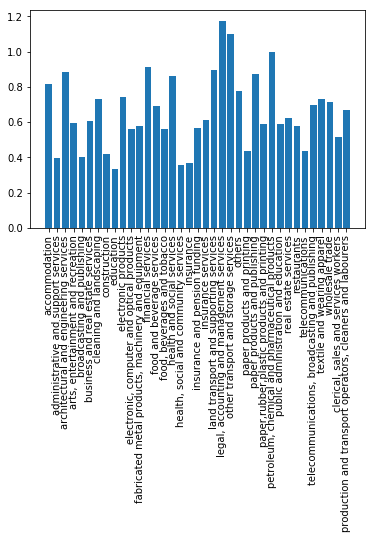

In [30]:
sortlist = {}

for i, items in enumerate (Feature.columns):
    print('%s: %f' % (items, fs.scores_[i]))
    sortlist[items] =  fs.scores_[i]
    
# plot the scores
pyplot.bar(Feature.columns, fs.scores_)
pyplot.xticks(rotation=90)
pyplot.show()

In [31]:
sorted(sortlist.items(), key=lambda x: x[1])

[('education', 0.33221478620986544),
 ('health, social and community services', 0.3543610216191082),
 ('insurance', 0.36876839860928157),
 ('administrative and support services', 0.3934329879569487),
 ('broadcasting and publishing', 0.40414809308937083),
 ('construction', 0.4197714435137403),
 ('telecommunications', 0.4338611579469003),
 ('paper products and printing', 0.4349583037008824),
 ('clerical, sales and services workers', 0.5162090799074437),
 ('food, beverages and tobacco', 0.560816303786333),
 ('electronic, computer and optical products', 0.5624798338358028),
 ('insurance and pension funding', 0.5640396529456537),
 ('fabricated metal products, machinery and equipment', 0.5774918898847319),
 ('restaurants', 0.579274362631089),
 ('public administration and education', 0.5869631911181172),
 ('paper,rubber,plastic products and printing', 0.5907621164324159),
 ('arts, entertainment and recreation', 0.5931007007962572),
 ('business and real estate services', 0.6059799860036026),
 

In [32]:
cols = fs.get_support(indices=True)
Last_Feature = Feature.iloc[:,cols]

In [33]:
# Manual_Features = Feature.loc[:,'clerical, sales and services workers']

### Integrate back Target and Feature

In [34]:
df_filtered = pd.concat([Last_Feature, Target], axis=1).reindex(Target.index)
first_column = df_filtered.pop('it and other information services')
df_filtered.insert(0, 'it and other information services', first_column)
df_filtered

,it and other information services,"legal, accounting and management services",other transport and storage services
Date,,,
1990-03-31,0.0,0.0,0.0
1990-06-30,0.0,0.0,0.0
1990-09-30,0.0,0.0,0.0
1990-12-31,0.0,0.0,0.0
1991-03-31,0.0,0.0,0.0
...,...,...,...
2020-06-30,3300.0,2100.0,400.0
2020-09-30,4300.0,2600.0,900.0
2020-12-31,4200.0,2200.0,1000.0


In [35]:
# df_filtered[['it and other information services','financial services','legal, accounting and management services','other adminstrative and support services']].plot(figsize=(20,6))

# Data scaling & Assigning train_test set

In [36]:
df_full = df_filtered.copy()
df_future = df_full[-8:]
df_train = df_full[:-8]

In [37]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_transformed = scaler.fit_transform(df_train)

## Sequence split
### 0 - 100 predict 101,102 ... 108
### 1 - 101 predict 102,103 ... 109

In [38]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Model

## Model 1 - LSTM

In [39]:
# [samples, timesteps, features]

n_steps_in, n_steps_out = 50, 8

# split into samples
X, y = split_sequence(df_transformed, n_steps_in, n_steps_out)

n_features = len(df_filtered.columns)
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))

print(X.shape)
print(y.shape)

print(X[:-1].shape)
print(y[:-1].shape)

(61, 50, 3)
(61, 8, 3)
(60, 50, 3)
(60, 8, 3)


In [40]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mae')
# fit model
model.fit(X[:-1], y[:-1], epochs=85, verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/85
60/60 [==============================] - 1s 21ms/sample - loss: 0.3754
Epoch 2/85
60/60 [==============================] - 0s 1ms/sample - loss: 0.3579
Epoch 3/85
60/60 [==============================] - 0s 1ms/sample - loss: 0.3395
Epoch 4/85
60/60 [==============================] - 0s 1ms/sample - loss: 0.3182
Epoch 5/85
60/60 [==============================] - 0s 1ms/sample - loss: 0.2905
Epoch 6/85
60/60 [==============================] - 0s 1ms/sample - loss: 0.2521
Epoch 7/85
60/60 [==============================] - 0s 1ms/sample - loss: 0.1988
Epoch 8/85
60/60 [==============================] - 0s 1ms/sample - loss: 0.1527
Epoch 9/85
60/60 [==============================] - 0s 1ms/sample - loss: 0.1715
Epoch 10/85
60/60 [==============================] - 0s 1ms/sample - loss: 0.1490
Epoch 11/85
60/60 [==============================] - 0s 1ms/sample -

In [41]:
# demonstrate prediction
x_pred = X[-1].reshape((1, X[-1].shape[0], n_features))
y_pred = model.predict(x_pred, verbose=1)
y_pred = scaler.inverse_transform(y_pred[0])

1/1 [==============================] - 0s 172ms/sample


C:\Users\RAVEN\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


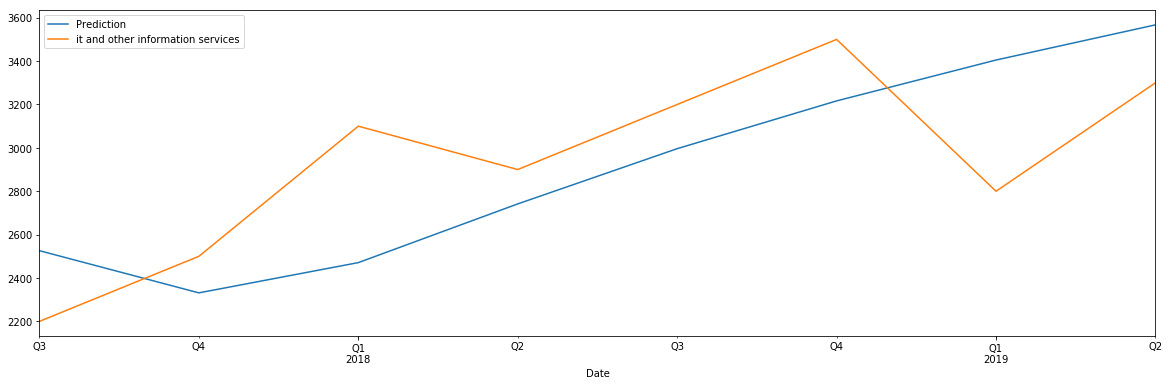

In [42]:
df_validate = df_train[-(n_steps_out):]
df_validate["Prediction"] = y_pred[:,0]
df_validate[["Prediction", "it and other information services"]].plot(figsize=(20,6))

In [43]:
rmse = math.sqrt(mean_squared_error(df_validate["it and other information services"], df_validate["Prediction"]))
mape = mean_absolute_percentage_error(df_validate["it and other information services"], df_validate["Prediction"])

print('RMSE: %.2f' % (rmse))
print('MAPE: %.2f' % (mape))

RMSE: 373.26
MAPE: 0.11


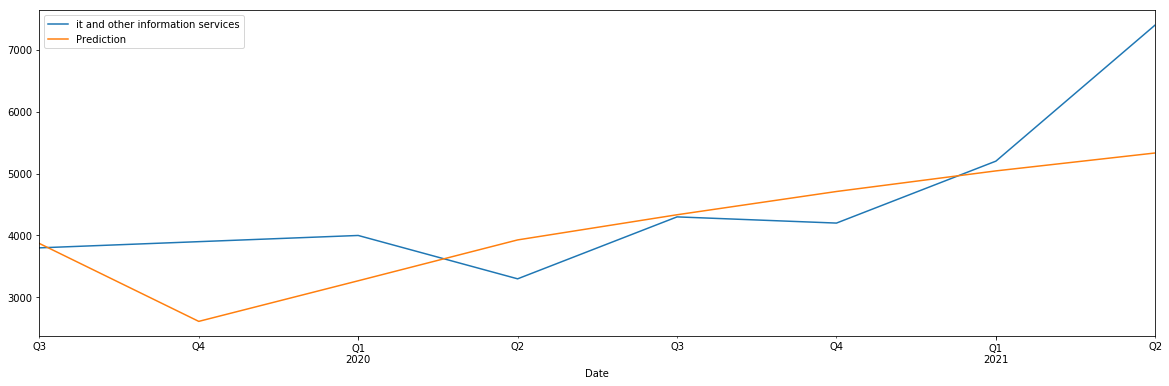

In [44]:
future_X = df_transformed[-(n_steps_in+1):-1].reshape((1, n_steps_in, n_features))

future_Y = model.predict(future_X)
future_Y = scaler.inverse_transform(future_Y[0])

df_future = df_future.sort_index(ascending=True)
df_future = df_future[["it and other information services"]]

df_future = df_future[-(n_steps_out):]
df_future["Prediction"] = future_Y[:,0]
df_future.plot(figsize=(20,6))

In [45]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

testScore = math.sqrt(mean_squared_error(df_future["it and other information services"], df_future["Prediction"]))
testScore1 = mean_absolute_percentage_error(df_future["it and other information services"], df_future["Prediction"])

print('RMSE: %.2f' % (testScore))
print('MAPE: %.2f' % (testScore1))

RMSE: 945.61
MAPE: 0.15


## Model 2 - ConvLSTM

In [46]:
# [samples, timesteps, features]
# [samples, timesteps, rows, cols, features]

n_steps, n_length = 2, 25

# Reshape
n_features = len(df_filtered.columns)
X = X.reshape((X.shape[0], n_steps, 1, n_length, n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))

print(X.shape)
print(y.shape)

print(X[:-1].shape)
print(y[:-1].shape)

(61, 2, 1, 25, 3)
(61, 8, 3)
(60, 2, 1, 25, 3)
(60, 8, 3)


In [47]:
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='tanh', input_shape=(n_steps, 1, n_length, n_features)))
model.add(Flatten())
model.add(RepeatVector(n_steps_out))
model.add(LSTM(200, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='tanh')))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mae')

model.fit(X[:-1], y[:-1], epochs=200, verbose=1)

Epoch 1/200
60/60 [==============================] - 2s 30ms/sample - loss: 0.3134
Epoch 2/200
60/60 [==============================] - 0s 4ms/sample - loss: 0.1482
Epoch 3/200
60/60 [==============================] - 0s 5ms/sample - loss: 0.1423
Epoch 4/200
60/60 [==============================] - 0s 5ms/sample - loss: 0.1135
Epoch 5/200
60/60 [==============================] - 0s 5ms/sample - loss: 0.1193
Epoch 6/200
60/60 [==============================] - 0s 5ms/sample - loss: 0.1089
Epoch 7/200
60/60 [==============================] - 0s 5ms/sample - loss: 0.0979
Epoch 8/200
60/60 [==============================] - 0s 5ms/sample - loss: 0.0973
Epoch 9/200
60/60 [==============================] - 0s 5ms/sample - loss: 0.0960
Epoch 10/200
60/60 [==============================] - 0s 5ms/sample - loss: 0.0901
Epoch 11/200
60/60 [==============================] - 0s 5ms/sample - loss: 0.0879
Epoch 12/200
60/60 [==============================] - 0s 5ms/sample - loss: 0.0892
Epoch 13/200

In [48]:
x_pred = X[-1].reshape((1, X[-1].shape[0], 1, 25, n_features))
y_pred = model.predict(x_pred, verbose=1)
y_pred = scaler.inverse_transform(y_pred[0])

1/1 [==============================] - 0s 281ms/sample


C:\Users\RAVEN\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


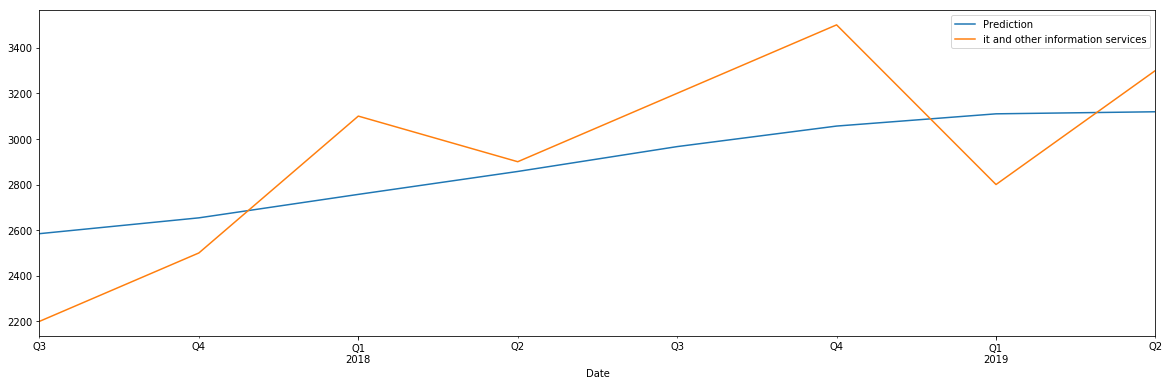

In [49]:
df_validate = df_train[-(n_steps_out):]
df_validate["Prediction"] = y_pred[:,0]
df_validate[["Prediction", "it and other information services"]].plot(figsize=(20,6))

In [50]:
rmse = math.sqrt(mean_squared_error(df_validate["it and other information services"], df_validate["Prediction"]))
mape = mean_absolute_percentage_error(df_validate["it and other information services"], df_validate["Prediction"])

print('RMSE: %.2f' % (rmse))
print('MAPE: %.2f' % (mape))

RMSE: 289.72
MAPE: 0.09


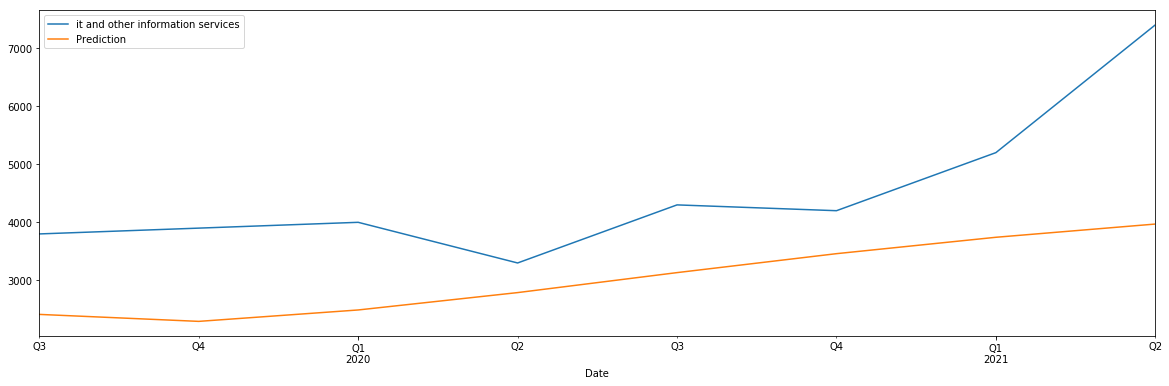

In [51]:
future_X = df_transformed[-(n_steps_in+1):-1].reshape((1, 2, 1, 25, n_features))

future_Y = model.predict(future_X)
future_Y = scaler.inverse_transform(future_Y[0])

df_future = df_future.sort_index(ascending=True)
df_future = df_future[["it and other information services"]]

df_future = df_future[-(n_steps_out):]
df_future["Prediction"] = future_Y[:,0]
df_future.plot(figsize=(20,6))

In [52]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

testScore = math.sqrt(mean_squared_error(df_future["it and other information services"], df_future["Prediction"]))
testScore1 = mean_absolute_percentage_error(df_future["it and other information services"], df_future["Prediction"])

print('RMSE: %.2f' % (testScore))
print('MAPE: %.2f' % (testScore1))

RMSE: 1689.39
MAPE: 0.31


# Predict future

In [57]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_transformed_full = scaler.fit_transform(df_full)

In [95]:
n_steps_in, n_steps_out = 50, 8

# split into samples
X, y = split_sequence(df_transformed_full, n_steps_in, n_steps_out)

n_features = len(df_filtered.columns)
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))

print(X.shape)
print(y.shape)

(69, 50, 3)
(69, 8, 3)


In [96]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mae')
# fit model
model.fit(X, y, epochs=85, verbose=1)

Epoch 1/85
69/69 [==============================] - 2s 30ms/sample - loss: 0.3220
Epoch 2/85
69/69 [==============================] - 0s 2ms/sample - loss: 0.2942
Epoch 3/85
69/69 [==============================] - 0s 2ms/sample - loss: 0.2584
Epoch 4/85
69/69 [==============================] - 0s 2ms/sample - loss: 0.2093
Epoch 5/85
69/69 [==============================] - 0s 2ms/sample - loss: 0.1743
Epoch 6/85
69/69 [==============================] - 0s 2ms/sample - loss: 0.1643
Epoch 7/85
69/69 [==============================] - 0s 2ms/sample - loss: 0.1323
Epoch 8/85
69/69 [==============================] - 0s 2ms/sample - loss: 0.1313
Epoch 9/85
69/69 [==============================] - 0s 2ms/sample - loss: 0.1297
Epoch 10/85
69/69 [==============================] - 0s 2ms/sample - loss: 0.1292
Epoch 11/85
69/69 [==============================] - 0s 2ms/sample - loss: 0.1222
Epoch 12/85
69/69 [==============================] - 0s 2ms/sample - loss: 0.1185
Epoch 13/85
69/69 [=====

In [97]:
# demonstrate prediction
x_pred = X[-1].reshape((1, X[-1].shape[0], n_features))
y_pred = model.predict(x_pred, verbose=1)
y_pred = scaler.inverse_transform(y_pred[0])

1/1 [==============================] - 1s 507ms/sample


In [98]:
print(df_full.index.max())
df_forecast = pd.DataFrame()
df_forecast['Date'] = pd.date_range(start='7/1/2021', end='6/30/2023', freq ='Q')

2021-06-30 00:00:00


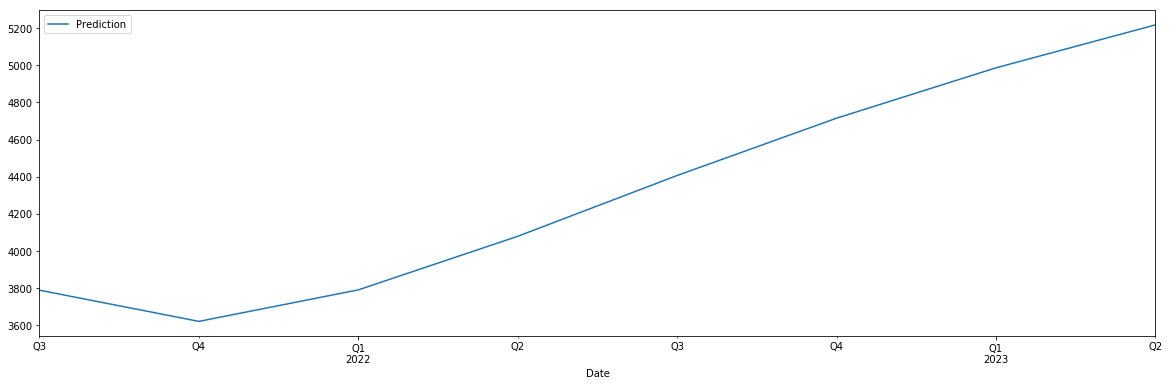

In [99]:
df_forecast["Prediction"] = y_pred[:,0]
df_forecast.set_index('Date', inplace = True)
df_forecast[["Prediction"]].plot(figsize=(20,6))

## Conclusion

#### -It is in continuous uptrend in future
#### -However, there is a surge in 2021 Q2 (outlier)
#### -Our model expect there is a retracement for the surge (as temporary no external variable to support that it may continue surge in the future) 



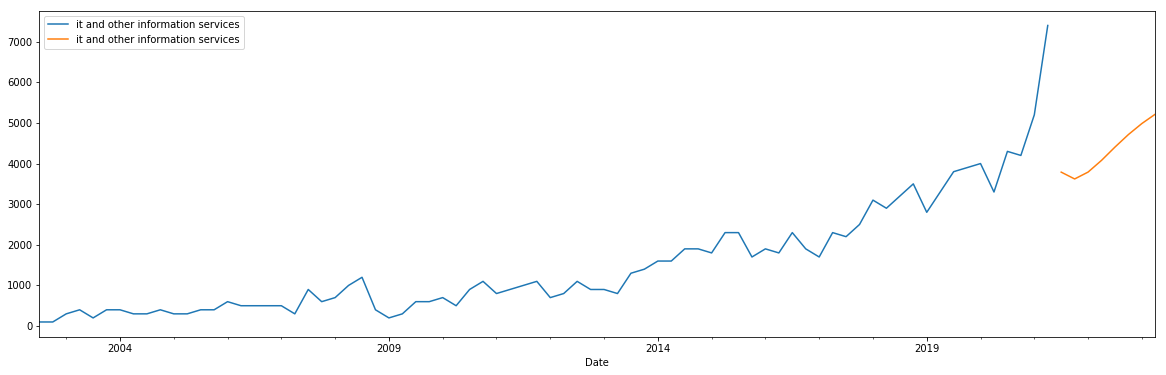

In [105]:
df_forecast = df_forecast.rename(columns={'Prediction': 'it and other information services'})
df_overall = pd.concat([df_full['it and other information services'], df_forecast['it and other information services']], axis=1)
df_overall[["it and other information services"]][50:].plot(figsize=(20,6))

## Future works
#### -Try to outsource the external event cause the surge and add in as variable
#### -This can further confirm future trend will be a retracement/ continuous extreme uptrend